In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .config("spark.memory.offHeap.enabled","true")
    .config("spark.memory.offHeap.size","12g")
    .getOrCreate()
)

spark.conf.set("spark.sql.shuffle.partitions", 10000)

your 131072x1 screen size is bogus. expect trouble
24/10/01 12:51:56 WARN Utils: Your hostname, LAPTOP-1A92TAQQ resolves to a loopback address: 127.0.1.1; using 172.18.166.45 instead (on interface eth0)
24/10/01 12:51:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/01 12:51:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
trans_sdf = spark.read.parquet("../data/merged/merged_transactions_with_tags.parquet")
print(trans_sdf.count())
trans_sdf.show(truncate=False)

13614854


24/10/01 12:52:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------------------------------------------------+-------+------------+------------------+------------------------------------+--------------+-----------------------------+-----------+------------------+--------------------------------+-----+--------+-----------+--------------------------+--------------------------+--------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------+--------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------+------------+--------------------+--------------------------+--------------------+--------+------------+---------+-----

## Feature Engineering 
- Keep the Merchant ABN
- Calculate the number of unique customers that come in everyday

### Goal: Model a Time Series Model for the unique customers that come in for every merchant AKA the growth in customers for every merchant
- Modelling the cumulative unique customers through the period of the transactions and forecast for the next 6 months
- Dependent variable : Cumulative Unique Customers
- Exogenous Variables: Merchant Fraud Probability, Consumer Fraud Probability (Does not depend on the time hence we can use as exogenous variables)

### Getting the unique number of customers coming in each day

In [3]:
from pyspark.sql.window import Window

# Define window spec based on merchant and order time
window_spec = Window.partitionBy('merchant_abn').orderBy('order_datetime').rowsBetween(Window.unboundedPreceding, Window.currentRow)
prev_window_spec = Window.partitionBy('merchant_abn').orderBy('order_datetime').rowsBetween(Window.unboundedPreceding, -1)

customer_count = trans_sdf.select("merchant_abn", "consumer_id", "order_datetime")

customer_count.cache()

customer_count = customer_count.withColumn('cumulative_customers', 
                                           F.collect_set('consumer_id').over(window_spec))

customer_count = customer_count.withColumn('previous_cumulative_customers', 
                                           F.collect_set('consumer_id').over(prev_window_spec))

customer_count = customer_count.withColumn('new_unique_customers', 
                                           F.expr("array_except(cumulative_customers, previous_cumulative_customers)"))

customer_count = customer_count.withColumn('num_new_unique_customers', 
                                           F.size('new_unique_customers'))

customer_count = customer_count.withColumn('num_cumulative_customers', 
                                           F.size('cumulative_customers'))

customer_count = customer_count.orderBy("merchant_abn", "order_datetime")

customer_count = customer_count.select("merchant_abn", "order_datetime", "num_cumulative_customers", "num_new_unique_customers")

customer_count.show()

+------------+--------------+------------------------+------------------------+
|merchant_abn|order_datetime|num_cumulative_customers|num_new_unique_customers|
+------------+--------------+------------------------+------------------------+
| 10023283211|    2021-02-28|                       1|                       1|
| 10023283211|    2021-02-28|                       2|                       1|
| 10023283211|    2021-02-28|                       3|                       1|
| 10023283211|    2021-03-01|                       4|                       1|
| 10023283211|    2021-03-01|                       5|                       1|
| 10023283211|    2021-03-02|                       6|                       1|
| 10023283211|    2021-03-02|                       7|                       1|
| 10023283211|    2021-03-02|                       8|                       1|
| 10023283211|    2021-03-02|                       9|                       1|
| 10023283211|    2021-03-03|           

Only Taking the top 200 Merchants with the most Unique Customers

In [4]:
unique_customer_count = trans_sdf.groupBy("merchant_abn").agg(F.countDistinct("consumer_id").alias("unique_consumer_count"))
print(unique_customer_count.count())
unique_customer_count.show(5, truncate=False)

4026


+------------+---------------------+
|merchant_abn|unique_consumer_count|
+------------+---------------------+
|96946925998 |131                  |
|18525353549 |890                  |
|68289707002 |2242                 |
|60616659469 |507                  |
|42735118354 |444                  |
+------------+---------------------+
only showing top 5 rows



In [5]:
sorted_df = unique_customer_count.orderBy(unique_customer_count['unique_consumer_count'].desc())

top_200_merchants = sorted_df.limit(200)
top_200_merchants_list = top_200_merchants.select("merchant_abn").distinct().rdd.flatMap(lambda x: x).collect()

In [7]:
## DO NOT RUN WILL TAKE 500 HOURS

# for merchant in top_200_merchants_list:
#     i += 1
#     print(i)
#     print(merchant)
#     customer_df = customer_count.filter(F.col("merchant_abn") == merchant).groupBy('merchant_abn', 'order_datetime') \
#         .agg(
#             F.max('num_cumulative_customers').alias('total_cumulative_customers'), 
#             F.sum('num_new_unique_customers').alias('total_new_unique_customers')
#         ) 
    
#     output_path = f"../data/customer/{merchant}_customer_data.parquet"  
    
#     customer_df.write.mode("overwrite").parquet(output_path)
    
#     print(f"Data for merchant {merchant} saved to {output_path}")

In [8]:
customer_sdf = spark.read.parquet("../data/top_200_customer/*")

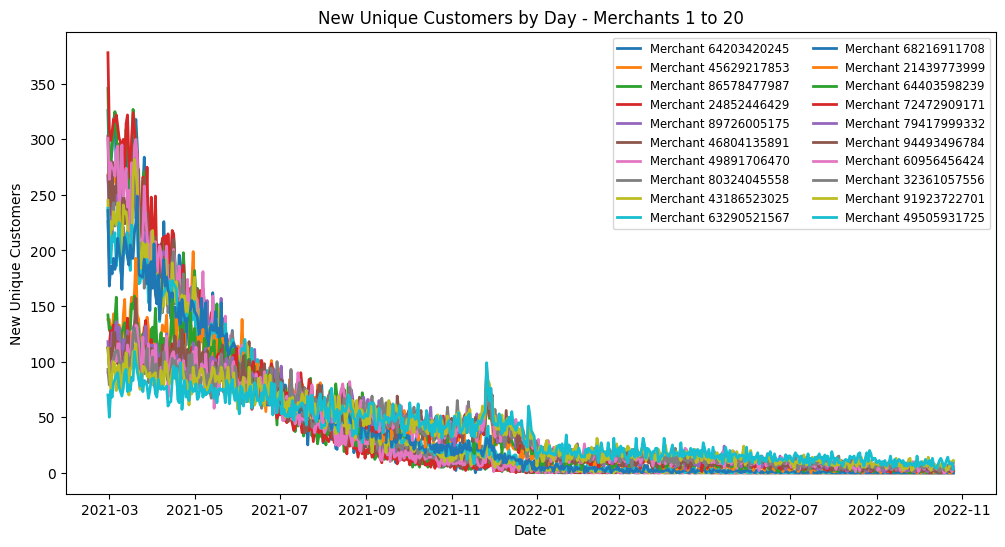

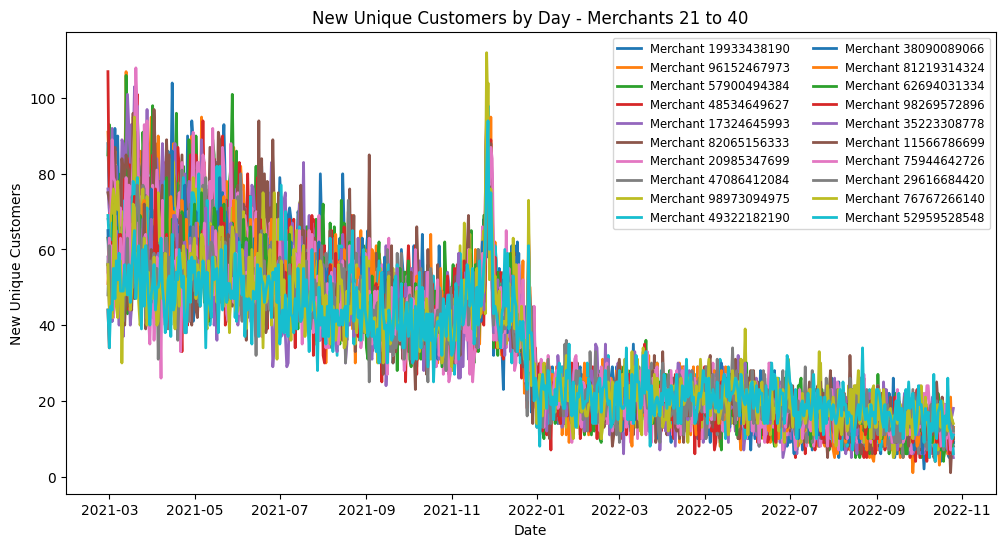

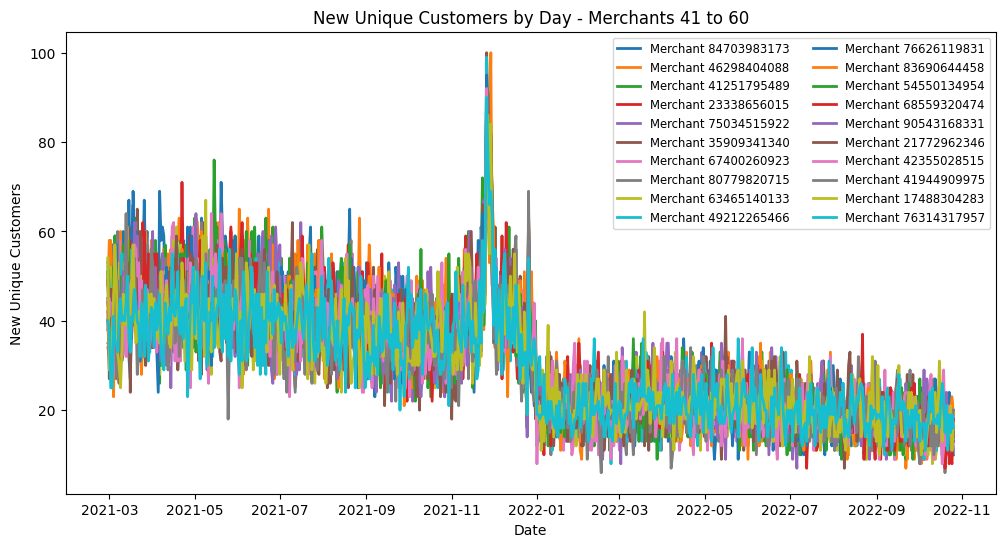

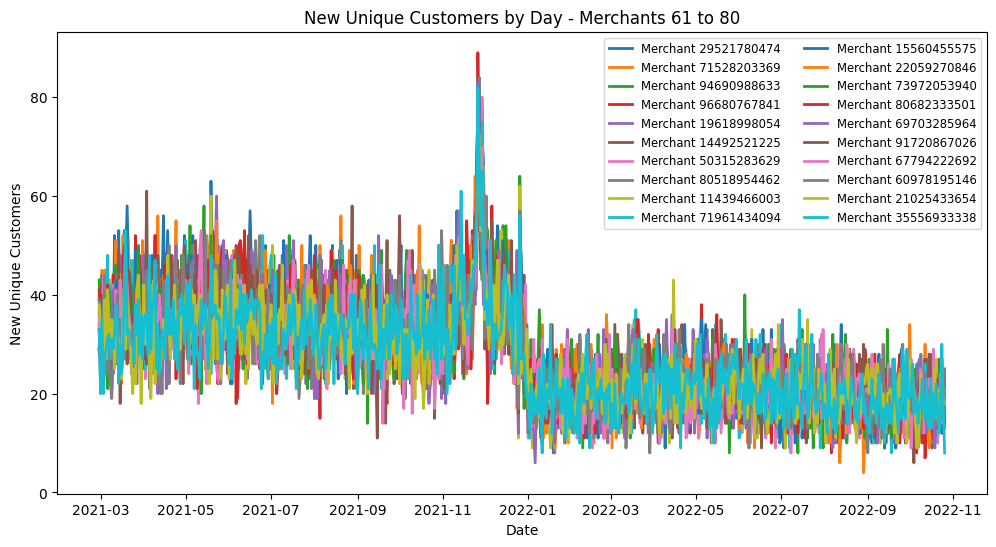

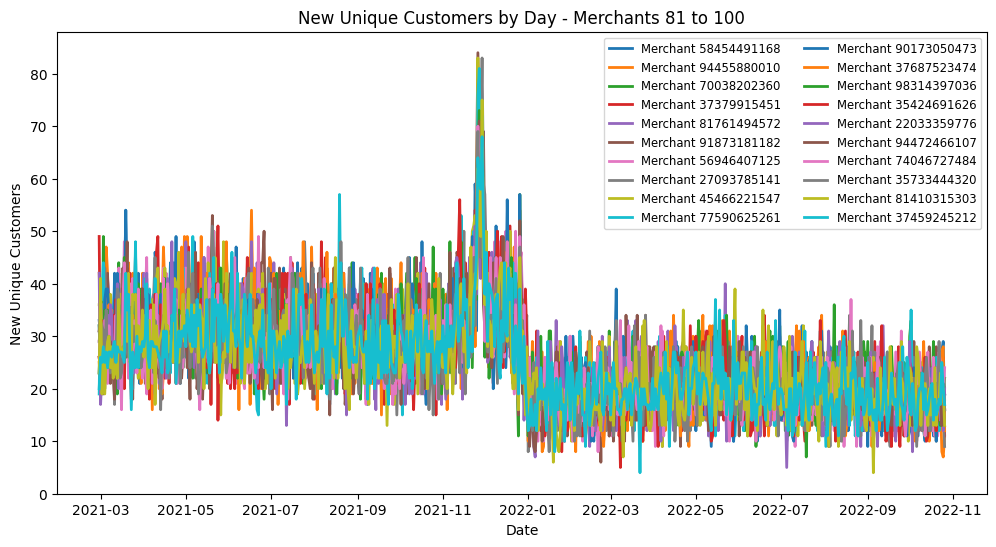

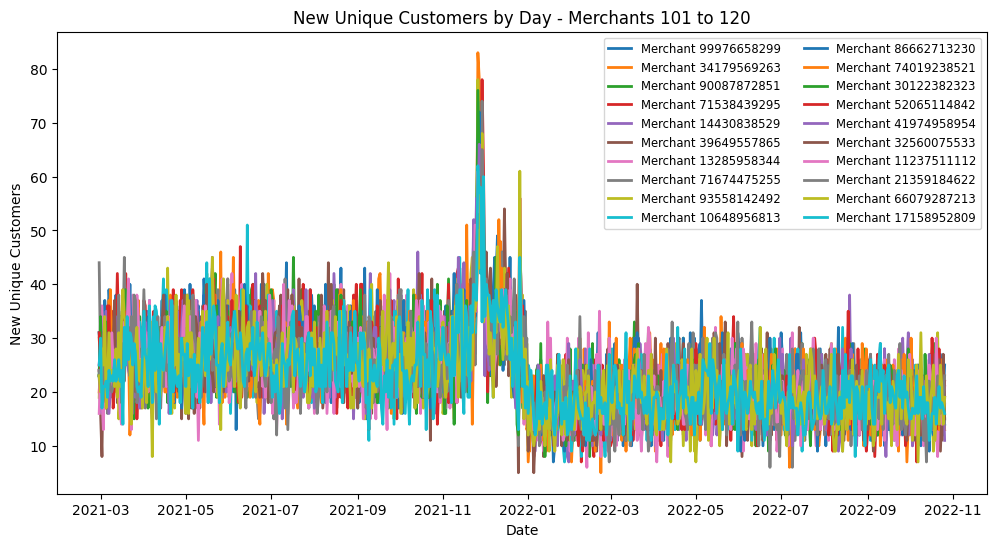

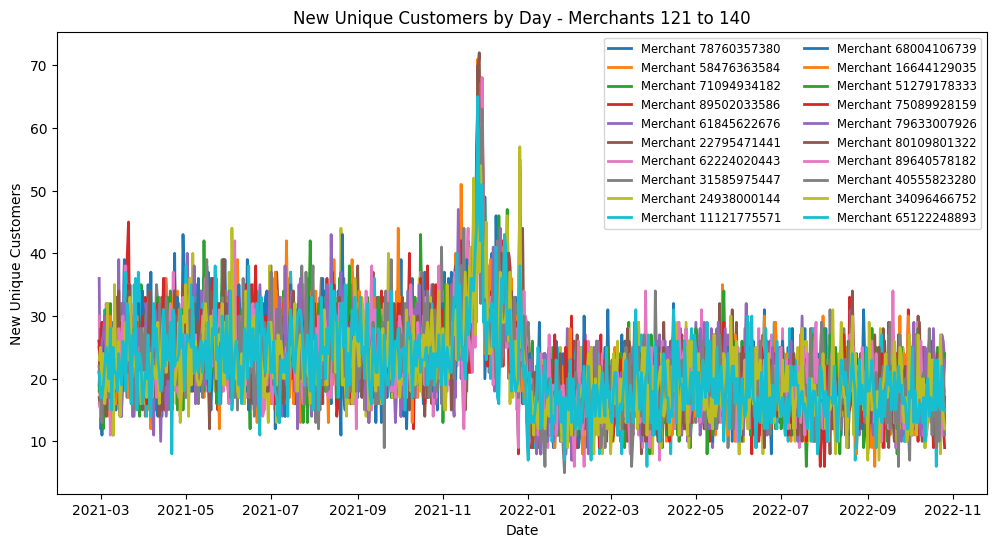

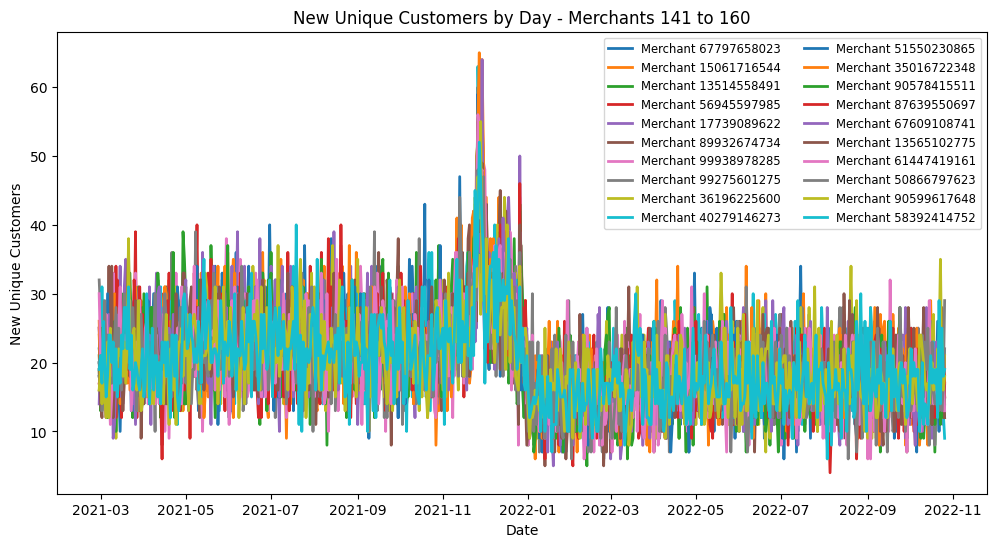

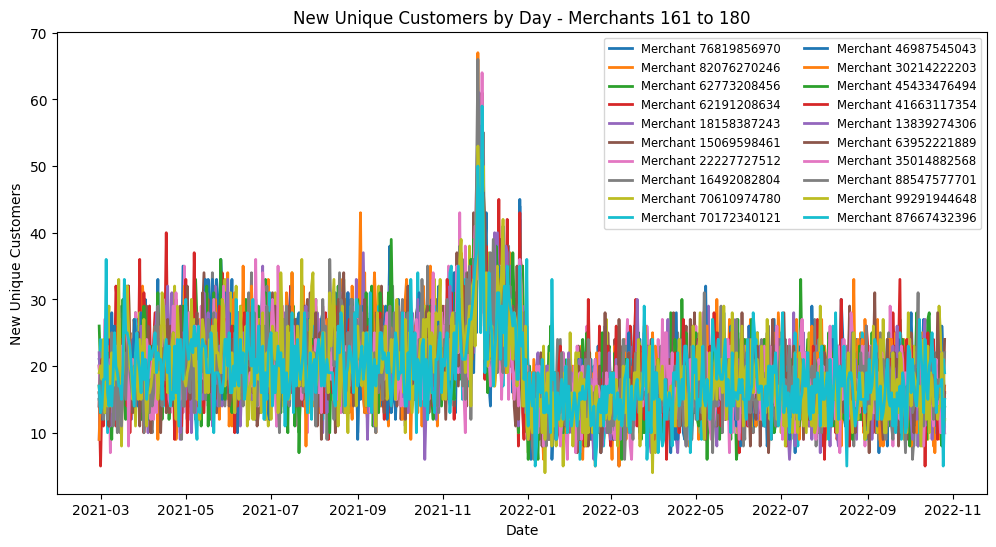

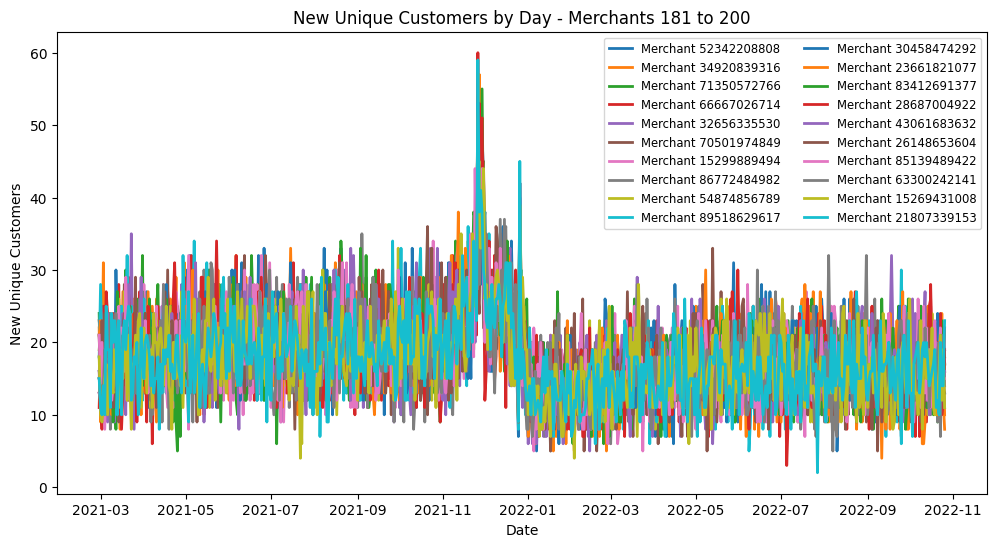

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming top_200_merchants_list is a list of merchant_abn for the top 200 merchants
group_size = 20  # 20 merchants per plot

# Loop through 10 groups (0-19, 20-39, ..., 180-199)
for i in range(0, 200, group_size):
    # Create a new plot
    plt.figure(figsize=(12, 6))
    
    # Iterate over each merchant in the group
    for merchant_abn in top_200_merchants_list[i:i+group_size]:
        # Filter the DataFrame for the current merchant and convert it to pandas
        example = customer_sdf.filter(F.col('merchant_abn') == merchant_abn).toPandas()
        example.set_index('order_datetime', inplace=True)
        
        # Plot the merchant's time series data (new unique customers over time)
        plt.plot(example['total_new_unique_customers'], label=f'Merchant {merchant_abn}', linewidth=2)
    
    # Add title, labels, and legend
    plt.title(f'New Unique Customers by Day - Merchants {i+1} to {i+group_size}')
    plt.xlabel("Date")
    plt.ylabel("New Unique Customers")
    plt.legend(loc="best", fontsize='small', ncol=2)  # Adjust legend for clarity
    
    # Show the plot
    plt.show()

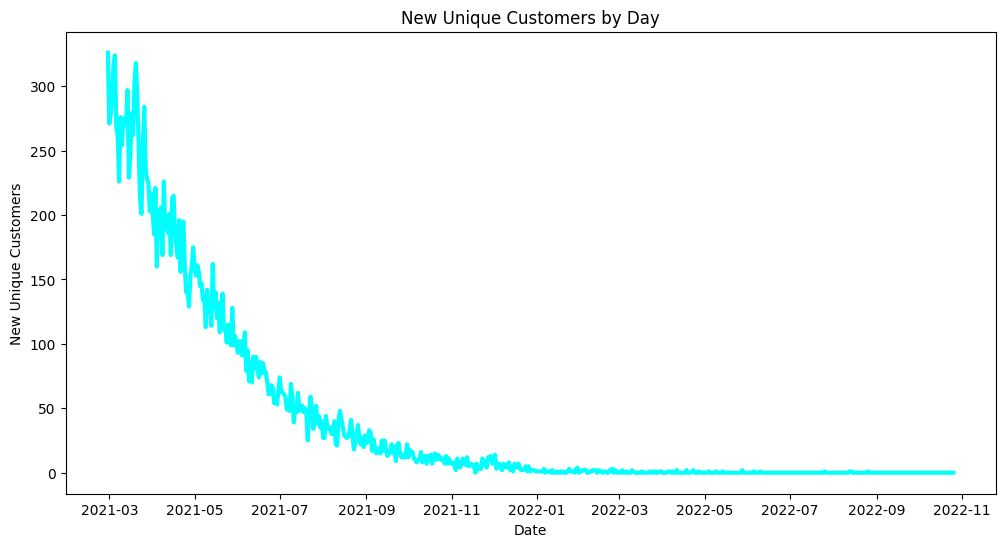

In [10]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

example = customer_sdf.filter(F.col('merchant_abn') == top_200_merchants_list[0]).toPandas()
example.set_index('order_datetime', inplace=True)

plt.figure(figsize=(12, 6)) 
plt.plot(example['total_new_unique_customers'], linewidth=3,c='cyan') 
plt.title('New Unique Customers by Day') 
plt.xlabel("Date") 
plt.ylabel("New Unique Customers") 
plt.show()

Merging to include the average consumer fraud and also the merchant fraud probability

In [11]:
revenue_sdf = spark.read.parquet("../data/curated/revenue.parquet")
revenue_sdf.show(5, truncate=False)

+------------+--------------+------------------------+-----------------------------+------------+---------+----------------+------------------+----------+------------+-----------------+---------+-------------+--------------------+----------------------------------+----------------------------------+-----------+------------------+
|merchant_abn|order_datetime|merchant_name           |description                  |revenue_band|take_rate|industry_segment|revenue           |male_count|female_count|undisclosed_count|num_trans|num_postcodes|num_unique_customers|average_consumer_fraud_probability|average_merchant_fraud_probability|fraud_count|mean_trans_val    |
+------------+--------------+------------------------+-----------------------------+------------+---------+----------------+------------------+----------+------------+-----------------+---------+-------------+--------------------+----------------------------------+----------------------------------+-----------+------------------+
|631

In [12]:
merged_df = customer_sdf.join(revenue_sdf.select('merchant_abn', 'order_datetime', 
                                'average_consumer_fraud_probability', 
                                'average_merchant_fraud_probability'), 
                     on=['merchant_abn', 'order_datetime'], 
                     how='inner')

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_model_for_merchant(merchant, growth_rate):

    merchant_data = customer_sdf.filter(F.col("merchant_abn") == merchant)
    merchant_pd = merchant_data.toPandas()

    merchant_pd['order_datetime'] = pd.to_datetime(merchant_pd['order_datetime'])
    merchant_pd.set_index('order_datetime', inplace=True)

    time_series_data = merchant_pd['total_cumulative_customers']

    model = SARIMAX(time_series_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), freq="D")
    fitted_model = model.fit(disp=False)

    forecast_steps = 180
    forecast = fitted_model.forecast(steps=forecast_steps)

    last_date = time_series_data.index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=forecast_steps, freq='D')
    forecast_series = pd.Series(forecast, index=forecast_index)

    # plt.figure(figsize=(10, 6))
    # plt.plot(time_series_data.index, time_series_data, label='Actual Data', color='blue')

    # plt.plot(forecast_series.index, forecast_series, label='6-Month Forecast', color='red', linestyle='--')

    # plt.title('SARIMAX Model - 6 Month Forecast of Cumulative Unique Customers')
    # plt.xlabel('Date')
    # plt.ylabel('Cumulative Unique Customers')
    # plt.legend()

    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()

    initial_value = forecast_series.iloc[0]
    final_value = forecast_series.iloc[-1]

    growth_rate_6_months = ((final_value / initial_value) - 1) * 100

    print(f"Merchant {merchant} growth rate over the next 6 months: {growth_rate_6_months:.2f}%")
    growth_rate.append(growth_rate_6_months)


In [36]:
growth_rate = []
growth_dict = {}

for merchant in top_200_merchants_list:
    train_model_for_merchant(merchant, growth_rate)

for index, merchant in enumerate(top_200_merchants_list):
    growth_dict[merchant] = growth_rate[index]

/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Merchant 64203420245 growth rate over the next 6 months: -1.68%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Merchant 45629217853 growth rate over the next 6 months: -1.25%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 86578477987 growth rate over the next 6 months: -0.61%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Merchant 24852446429 growth rate over the next 6 months: -1.95%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 89726005175 growth rate over the next 6 months: -2.06%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Merchant 46804135891 growth rate over the next 6 months: -0.53%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Merchant 49891706470 growth rate over the next 6 months: -1.31%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 80324045558 growth rate over the next 6 months: -7.11%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 43186523025 growth rate over the next 6 months: -4.74%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 63290521567 growth rate over the next 6 months: -5.81%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 68216911708 growth rate over the next 6 months: -2.71%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 21439773999 growth rate over the next 6 months: -6.43%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 64403598239 growth rate over the next 6 months: -5.31%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 72472909171 growth rate over the next 6 months: -2.58%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 79417999332 growth rate over the next 6 months: -5.88%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 94493496784 growth rate over the next 6 months: -5.69%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 60956456424 growth rate over the next 6 months: -6.54%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 32361057556 growth rate over the next 6 months: -5.30%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 91923722701 growth rate over the next 6 months: 2.16%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 49505931725 growth rate over the next 6 months: 0.89%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 19933438190 growth rate over the next 6 months: 0.60%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 96152467973 growth rate over the next 6 months: 5.22%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 57900494384 growth rate over the next 6 months: 1.17%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 48534649627 growth rate over the next 6 months: 7.42%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 17324645993 growth rate over the next 6 months: 1.25%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 82065156333 growth rate over the next 6 months: 6.83%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 20985347699 growth rate over the next 6 months: 2.50%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 47086412084 growth rate over the next 6 months: 10.07%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 98973094975 growth rate over the next 6 months: 7.52%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 49322182190 growth rate over the next 6 months: 6.18%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 38090089066 growth rate over the next 6 months: 10.30%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 81219314324 growth rate over the next 6 months: 8.39%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 62694031334 growth rate over the next 6 months: 10.33%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 98269572896 growth rate over the next 6 months: 10.51%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 35223308778 growth rate over the next 6 months: 13.84%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 11566786699 growth rate over the next 6 months: 12.01%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 75944642726 growth rate over the next 6 months: 14.48%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 29616684420 growth rate over the next 6 months: 11.93%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 76767266140 growth rate over the next 6 months: 14.81%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 52959528548 growth rate over the next 6 months: 12.65%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 84703983173 growth rate over the next 6 months: 13.20%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 46298404088 growth rate over the next 6 months: 14.39%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 41251795489 growth rate over the next 6 months: 17.23%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 23338656015 growth rate over the next 6 months: 16.31%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 75034515922 growth rate over the next 6 months: 18.84%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 35909341340 growth rate over the next 6 months: 19.82%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 67400260923 growth rate over the next 6 months: 19.12%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 80779820715 growth rate over the next 6 months: 18.39%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 63465140133 growth rate over the next 6 months: 19.10%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 49212265466 growth rate over the next 6 months: 22.13%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 76626119831 growth rate over the next 6 months: 19.83%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 83690644458 growth rate over the next 6 months: 21.05%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 54550134954 growth rate over the next 6 months: 17.74%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 68559320474 growth rate over the next 6 months: 14.64%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 90543168331 growth rate over the next 6 months: 18.73%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 21772962346 growth rate over the next 6 months: 21.41%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 42355028515 growth rate over the next 6 months: 20.28%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 41944909975 growth rate over the next 6 months: 22.02%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 17488304283 growth rate over the next 6 months: 21.14%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 76314317957 growth rate over the next 6 months: 21.89%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 29521780474 growth rate over the next 6 months: 22.26%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 71528203369 growth rate over the next 6 months: 17.92%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 94690988633 growth rate over the next 6 months: 21.65%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 96680767841 growth rate over the next 6 months: 22.29%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 19618998054 growth rate over the next 6 months: 23.07%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 14492521225 growth rate over the next 6 months: 21.82%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 50315283629 growth rate over the next 6 months: 22.18%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 80518954462 growth rate over the next 6 months: 21.22%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 11439466003 growth rate over the next 6 months: 23.60%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 71961434094 growth rate over the next 6 months: 23.38%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 15560455575 growth rate over the next 6 months: 24.63%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 22059270846 growth rate over the next 6 months: 24.17%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 73972053940 growth rate over the next 6 months: 25.48%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 80682333501 growth rate over the next 6 months: 26.75%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 69703285964 growth rate over the next 6 months: 25.30%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 91720867026 growth rate over the next 6 months: 23.55%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 67794222692 growth rate over the next 6 months: 24.25%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 60978195146 growth rate over the next 6 months: 21.70%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 21025433654 growth rate over the next 6 months: 24.17%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 35556933338 growth rate over the next 6 months: 24.51%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 58454491168 growth rate over the next 6 months: 27.77%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 94455880010 growth rate over the next 6 months: 22.04%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 70038202360 growth rate over the next 6 months: 24.87%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 37379915451 growth rate over the next 6 months: 25.50%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 81761494572 growth rate over the next 6 months: 23.43%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 91873181182 growth rate over the next 6 months: 26.90%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Merchant 56946407125 growth rate over the next 6 months: 24.76%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 27093785141 growth rate over the next 6 months: 24.86%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 45466221547 growth rate over the next 6 months: 25.93%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 77590625261 growth rate over the next 6 months: 26.52%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 90173050473 growth rate over the next 6 months: 26.10%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 37687523474 growth rate over the next 6 months: 24.22%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Merchant 98314397036 growth rate over the next 6 months: 24.45%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 35424691626 growth rate over the next 6 months: 24.50%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 22033359776 growth rate over the next 6 months: 27.01%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 94472466107 growth rate over the next 6 months: 25.69%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 74046727484 growth rate over the next 6 months: 26.80%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Merchant 35733444320 growth rate over the next 6 months: 25.77%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 81410315303 growth rate over the next 6 months: 26.06%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 37459245212 growth rate over the next 6 months: 27.39%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 99976658299 growth rate over the next 6 months: 26.45%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 34179569263 growth rate over the next 6 months: 27.60%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 90087872851 growth rate over the next 6 months: 25.66%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 71538439295 growth rate over the next 6 months: 27.38%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 14430838529 growth rate over the next 6 months: 27.79%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Merchant 39649557865 growth rate over the next 6 months: 26.82%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 13285958344 growth rate over the next 6 months: 27.81%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 71674475255 growth rate over the next 6 months: 28.48%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 93558142492 growth rate over the next 6 months: 27.65%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 10648956813 growth rate over the next 6 months: 24.96%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 86662713230 growth rate over the next 6 months: 27.48%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 74019238521 growth rate over the next 6 months: 26.59%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 30122382323 growth rate over the next 6 months: 25.26%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 52065114842 growth rate over the next 6 months: 28.30%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 41974958954 growth rate over the next 6 months: 27.45%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 32560075533 growth rate over the next 6 months: 26.46%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 11237511112 growth rate over the next 6 months: 27.38%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Merchant 21359184622 growth rate over the next 6 months: 28.06%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 66079287213 growth rate over the next 6 months: 27.58%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 17158952809 growth rate over the next 6 months: 27.35%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 78760357380 growth rate over the next 6 months: 25.89%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 58476363584 growth rate over the next 6 months: 27.64%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 71094934182 growth rate over the next 6 months: 26.57%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 89502033586 growth rate over the next 6 months: 27.88%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 61845622676 growth rate over the next 6 months: 28.82%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 22795471441 growth rate over the next 6 months: 27.32%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 62224020443 growth rate over the next 6 months: 27.66%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 31585975447 growth rate over the next 6 months: 26.63%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 24938000144 growth rate over the next 6 months: 27.06%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 11121775571 growth rate over the next 6 months: 24.53%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 68004106739 growth rate over the next 6 months: 27.35%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 16644129035 growth rate over the next 6 months: 25.66%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 51279178333 growth rate over the next 6 months: 29.08%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 75089928159 growth rate over the next 6 months: 26.66%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 79633007926 growth rate over the next 6 months: 29.32%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 80109801322 growth rate over the next 6 months: 28.01%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 89640578182 growth rate over the next 6 months: 27.18%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 40555823280 growth rate over the next 6 months: 27.02%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Merchant 34096466752 growth rate over the next 6 months: 27.64%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 65122248893 growth rate over the next 6 months: 27.47%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 67797658023 growth rate over the next 6 months: 27.16%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 15061716544 growth rate over the next 6 months: 26.89%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 13514558491 growth rate over the next 6 months: 27.23%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Merchant 56945597985 growth rate over the next 6 months: 27.71%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 17739089622 growth rate over the next 6 months: 28.25%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 89932674734 growth rate over the next 6 months: 28.78%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 99938978285 growth rate over the next 6 months: 27.50%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 99275601275 growth rate over the next 6 months: 27.88%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 36196225600 growth rate over the next 6 months: 28.94%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Merchant 40279146273 growth rate over the next 6 months: 28.02%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 51550230865 growth rate over the next 6 months: 28.15%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 35016722348 growth rate over the next 6 months: 28.83%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 90578415511 growth rate over the next 6 months: 27.22%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 87639550697 growth rate over the next 6 months: 28.65%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 67609108741 growth rate over the next 6 months: 29.23%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 13565102775 growth rate over the next 6 months: 27.25%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 61447419161 growth rate over the next 6 months: 28.11%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 50866797623 growth rate over the next 6 months: 28.10%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 90599617648 growth rate over the next 6 months: 29.04%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 58392414752 growth rate over the next 6 months: 29.28%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 76819856970 growth rate over the next 6 months: 28.35%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 82076270246 growth rate over the next 6 months: 28.04%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 62773208456 growth rate over the next 6 months: 28.10%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 62191208634 growth rate over the next 6 months: 28.03%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 18158387243 growth rate over the next 6 months: 28.54%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 15069598461 growth rate over the next 6 months: 27.66%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 22227727512 growth rate over the next 6 months: 28.62%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Merchant 16492082804 growth rate over the next 6 months: 29.31%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 70610974780 growth rate over the next 6 months: 29.20%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 70172340121 growth rate over the next 6 months: 27.67%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 46987545043 growth rate over the next 6 months: 27.90%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 30214222203 growth rate over the next 6 months: 26.68%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 45433476494 growth rate over the next 6 months: 28.21%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 41663117354 growth rate over the next 6 months: 28.06%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 13839274306 growth rate over the next 6 months: 28.57%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 63952221889 growth rate over the next 6 months: 28.57%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 35014882568 growth rate over the next 6 months: 25.71%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 88547577701 growth rate over the next 6 months: 28.55%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 99291944648 growth rate over the next 6 months: 27.68%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 87667432396 growth rate over the next 6 months: 26.78%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Merchant 52342208808 growth rate over the next 6 months: 28.23%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 34920839316 growth rate over the next 6 months: 28.15%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 71350572766 growth rate over the next 6 months: 28.80%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 66667026714 growth rate over the next 6 months: 29.35%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 32656335530 growth rate over the next 6 months: 29.24%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 70501974849 growth rate over the next 6 months: 29.02%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 15299889494 growth rate over the next 6 months: 27.40%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 86772484982 growth rate over the next 6 months: 28.77%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 54874856789 growth rate over the next 6 months: 27.96%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 89518629617 growth rate over the next 6 months: 28.59%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 30458474292 growth rate over the next 6 months: 29.16%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 23661821077 growth rate over the next 6 months: 27.37%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 83412691377 growth rate over the next 6 months: 28.21%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 28687004922 growth rate over the next 6 months: 29.01%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 43061683632 growth rate over the next 6 months: 27.85%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 26148653604 growth rate over the next 6 months: 27.09%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 85139489422 growth rate over the next 6 months: 29.06%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 63300242141 growth rate over the next 6 months: 28.52%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Merchant 15269431008 growth rate over the next 6 months: 28.22%


/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Merchant 21807339153 growth rate over the next 6 months: 28.96%


In [42]:
growth_dict

{64203420245: np.float64(-1.6773035902993616),
 45629217853: np.float64(-1.2458183771950737),
 86578477987: np.float64(-0.6120491813503159),
 24852446429: np.float64(-1.9475070171150022),
 89726005175: np.float64(-2.0604164110300305),
 46804135891: np.float64(-0.5269931457696608),
 49891706470: np.float64(-1.3142773702705335),
 80324045558: np.float64(-7.108008016613665),
 43186523025: np.float64(-4.7404741942692175),
 63290521567: np.float64(-5.811250463386852),
 68216911708: np.float64(-2.713930755295868),
 21439773999: np.float64(-6.42917282991966),
 64403598239: np.float64(-5.310063249236152),
 72472909171: np.float64(-2.5771628418076897),
 79417999332: np.float64(-5.878410467331829),
 94493496784: np.float64(-5.694093560138547),
 60956456424: np.float64(-6.5374843939890015),
 32361057556: np.float64(-5.302350360008368),
 91923722701: np.float64(2.1580560308109176),
 49505931725: np.float64(0.8901423765349081),
 19933438190: np.float64(0.6046007250424701),
 96152467973: np.float64(

/home/chengmingliew/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44906D+00    |proj g|=  6.33215D-02


 This problem is unconstrained.



At iterate    5    f=  3.37995D+00    |proj g|=  2.43059D-02

At iterate   10    f=  3.36133D+00    |proj g|=  5.82456D-04

At iterate   15    f=  3.36128D+00    |proj g|=  1.08961D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   2.634D-06   3.361D+00
  F =   3.3612844026983741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


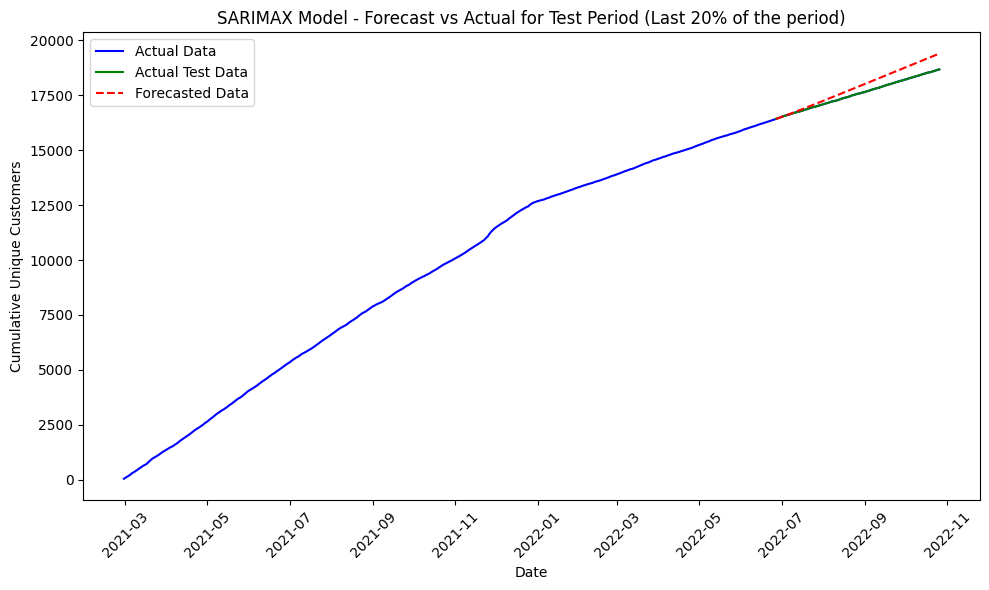

Merchant 21807339153 growth rate over the next 6 months: 18.09%


In [40]:
merchant_data = customer_sdf.filter(F.col("merchant_abn") == top_200_merchants_list[100])
merchant_pd = merchant_data.toPandas()

merchant_pd['order_datetime'] = pd.to_datetime(merchant_pd['order_datetime'])
merchant_pd.set_index('order_datetime', inplace=True)

time_series_data = merchant_pd['total_cumulative_customers']

split_point = int(len(time_series_data) * 0.8)

train_data = time_series_data[:split_point]
test_data = time_series_data[split_point:]

model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), freq="D")
fitted_model = model.fit(disp=False)

fitted_model = model.fit()

# Forecast for the test period with exogenous variables
forecast = fitted_model.forecast(steps=len(test_data))

# Plot the actual data, the test data, and the forecast
plt.figure(figsize=(10, 6))

# Plot the entire dataset
plt.plot(time_series_data.index, time_series_data, label='Actual Data', color='blue')

# Plot the actual test data
plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')

# Plot the forecasted data for the test period
plt.plot(test_data.index, forecast, label='Forecasted Data', color='red', linestyle='--')

# Add titles and labels
plt.title('SARIMAX Model - Forecast vs Actual for Test Period (Last 20% of the period)')
plt.xlabel('Date')
plt.ylabel('Cumulative Unique Customers')
plt.legend()

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

initial_value = forecast.iloc[0]
final_value = forecast.iloc[-1]

growth_rate_6_months = ((final_value / initial_value) - 1) * 100

print(f"Merchant {merchant} growth rate over the next 6 months: {growth_rate_6_months:.2f}%")
growth_rate.append(growth_rate_6_months)